# Определение наиболее выгодного региона нефтедобычи

На основе данных геологи разведки выбрать район добычи нефти

Шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

## Загрузка и подготовка данных

### Загрузка

In [3]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

# Сохраняем признак региона
df0['region'] = 0
df1['region'] = 1
df2['region'] = 2

# Объединяем
df = pd.concat([df0 ,df1, df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
 5   region   300000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 16.0+ MB


* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей)
* region (0, 1, 2)

### EDA

#### Исследуем признаки


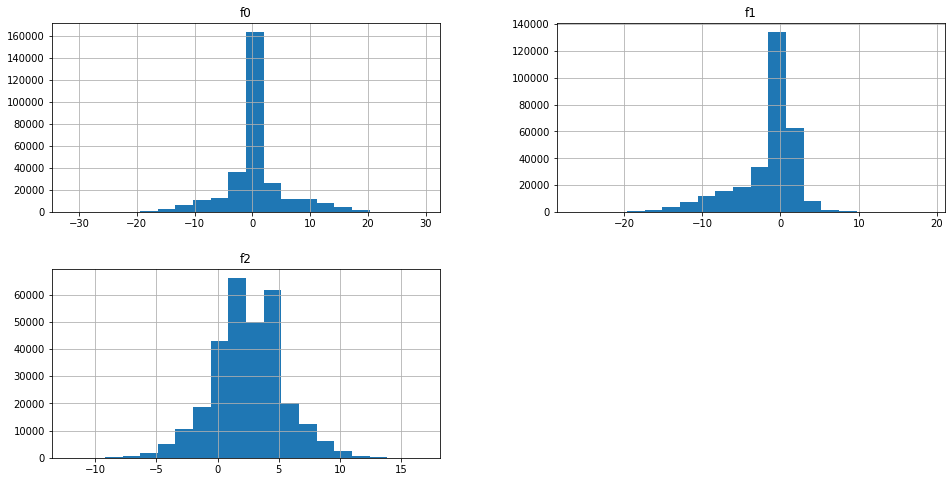

In [4]:
df[['f0','f1','f2']].hist(bins=20, figsize=(16, 8));

* Выраженное нормальное распределение признаков
* Каких-либо явных выбросов не обнаружено

#### Исследуем объем запасов

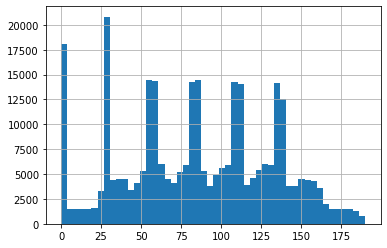

In [5]:
df['product'].hist(bins=50);

In [6]:
zero_count = (df['product'] == 0).sum()
print('Всего нулевых значений :',zero_count , ' из ', len(df), '(', zero_count/len(df)*100, '%)')

Всего нулевых значений : 8237  из  300000 ( 2.7456666666666667 %)


* На графике объема наблюдаются ярко выраженные пики через равные прожутки
* Большое количество значений около 0. Чисто нулевых значений не так много 

#### Исследуем средний объем запасов по регионам

In [7]:
product_grouped = df.groupby('region')['product'].mean()
product_grouped

region
0    92.500
1    68.825
2    95.000
Name: product, dtype: float64

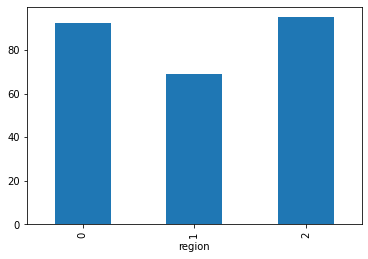

In [8]:
product_grouped.plot(kind = 'bar');

* Наименьший объем запасов в 1 регионе
* Объем запасов в 0 и 2 регионе приблизительно одинаковый


#### Исследуем коррекляцию признаков (общая)


In [9]:
df.corr()

,f0,f1,f2,product,region
f0,1.000000,0.085495,-0.000849,-0.030439,-0.038270
f1,0.085495,1.000000,0.000002,0.137210,-0.026401
f2,-0.000849,0.000002,1.000000,0.533554,-0.001053
product,-0.030439,0.137210,0.533554,1.000000,0.021940
region,-0.038270,-0.026401,-0.001053,0.021940,1.000000


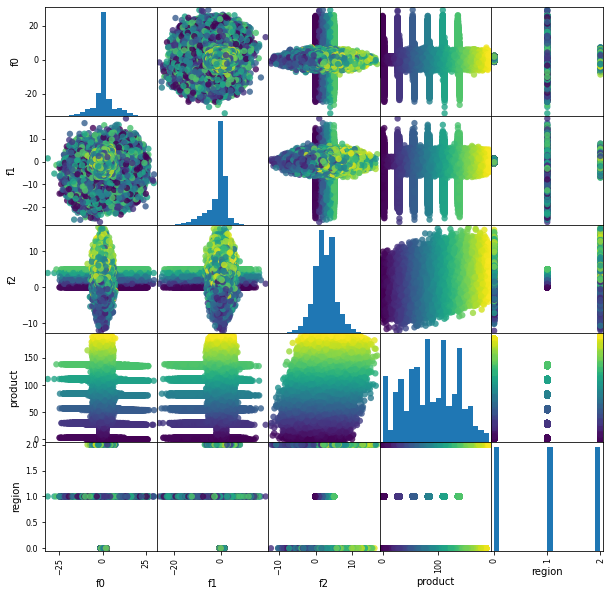

In [10]:
scat_mtrx = pd.plotting.scatter_matrix(df, c=df['product'], figsize=(10,10), marker='o',
                                      hist_kwds={'bins': 20}, s=40, alpha=.8);

* Корреляций между признакми не выявлено

#### Корреляция отдельно по регионам

In [11]:
df0.corr()

,f0,f1,f2,product,region
f0,1.000000,-0.440723,-0.003153,0.143536,NaN
f1,-0.440723,1.000000,0.001724,-0.192356,NaN
f2,-0.003153,0.001724,1.000000,0.483663,NaN
product,0.143536,-0.192356,0.483663,1.000000,NaN
region,NaN,NaN,NaN,NaN,NaN


In [12]:
df1.corr()

,f0,f1,f2,product,region
f0,1.000000,0.182287,-0.001777,-0.030491,NaN
f1,0.182287,1.000000,-0.002595,-0.010155,NaN
f2,-0.001777,-0.002595,1.000000,0.999397,NaN
product,-0.030491,-0.010155,0.999397,1.000000,NaN
region,NaN,NaN,NaN,NaN,NaN


In [13]:
df2.corr()

,f0,f1,f2,product,region
f0,1.000000,0.000528,-0.000448,-0.001987,NaN
f1,0.000528,1.000000,0.000779,-0.001012,NaN
f2,-0.000448,0.000779,1.000000,0.445871,NaN
product,-0.001987,-0.001012,0.445871,1.000000,NaN
region,NaN,NaN,NaN,NaN,NaN


* Выявлена очень сильная корреляция целевого признака региона 1 и f2

### Разделяем  и выделяем данные

In [14]:
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345)

print(df_train.shape, df_valid.shape)

(225000, 6) (75000, 6)


In [15]:
features = df.drop(['product', 'id', 'region'], axis=1)
target = df['product']

features_train = df_train.drop(['product', 'id', 'region'], axis=1)
target_train = df_train['product']

features_valid = df_valid.drop(['product', 'id', 'region'], axis=1)
target_valid = df_valid['product']

### Масштабируем данные для модели

In [16]:
scaler = StandardScaler()
scaler.fit(features_train)

numeric = ['f0', 'f1', 'f2']


features_train[numeric] = scaler.transform(features_train)
features_valid[numeric] = scaler.transform(features_valid)

features_train.head()

,f0,f1,f2
91812,0.061253,0.556838,-0.856317
55472,-0.779640,-2.662895,-0.514378
19672,-0.327690,0.489881,-0.184572
59062,-0.200989,0.650620,0.985479
31446,0.209819,0.320457,-0.328841


## Обучение и проверка модели

In [17]:
model = LinearRegression()

model.fit(features_train, target_train) 

LinearRegression()

In [18]:
# Предсказываем на валидационной выборке
predictions_valid = model.predict(features_valid)

result = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)

print("Среднее значение реальное:", target_valid.mean())
print("Среднее значение предсказания объема добычи:", predictions_valid.mean())

RMSE модели линейной регрессии на валидационной выборке: 38.78436364859428
Среднее значение реальное: 85.37435533280532
Среднее значение предсказания объема добычи: 85.5526857402352


* Среднее значение предсказанной моделью и реальных данных на валидационной выборке практически совпадают
* RMSE составляет 38.7, что очень много относительно среднего

## Подготовка к расчёту прибыли

### Константы

In [19]:
region_points_qnt = 500
region_target_points_qnt = 200
budget = 10_000_000_000
product_profit = 450_000
target_loss_coef = .025

###  Расчет минимального среднего количество продукта в месторождениях региона, достаточное для разработки

In [20]:
target_region_volume = budget // product_profit 
target_region_volume_unit = target_region_volume // region_target_points_qnt
target_region_volume_unit_delta = (target_region_volume_unit - target_valid.mean())/target_valid.mean() * 100
print('Для окупаемости в регионе нужно произвести порядка ', target_region_volume, ' тыс.барелей всеми скважинами')
print('Средний объем добычи одной отобранной скважины должен составлять ', target_region_volume_unit , 'тыс.барелей')
print('Средний объем добычи одной отобранной скважины должен превышать средний объем всех сважин реигона на ', target_region_volume_unit_delta , '%')

Для окупаемости в регионе нужно произвести порядка  22222  тыс.барелей всеми скважинами
Средний объем добычи одной отобранной скважины должен составлять  111 тыс.барелей
Средний объем добычи одной отобранной скважины должен превышать средний объем всех сважин реигона на  30.015623037270483 %


* Средний целевой объем добычи одной скажины в регионе превышает средний объем всех скважин
* Средний объем добычи отобранных скважин должен превышать средний объем всех скважин 

## Расчёт прибыли и рисков 

### Функция расчета прибыли

In [21]:
def calc_profit(data, unit_cost, total_budget):
    total_product = data.sum()
    total_profit = total_product * unit_cost
    return total_profit - total_budget

### Отбор скважин с максимальными объемом (по предсказаниям) и расчет прибыли

In [22]:
region_selected = []
for region in df['region'].unique():
    # Отбираеми данные
    selected = df.query('region == @region').sort_values('product', ascending = False).iloc[:region_target_points_qnt]
    features_selected = selected.drop(['product', 'id', 'region'], axis=1)
    # Прогнозируем по ним объемы производства
    predictions = model.predict(features_selected)
    # Рассчитываем прибыль по региону
    selected_profit = calc_profit(predictions, unit_cost = product_profit, total_budget = budget)
    # Сохраняем результат
    region_selected.append({'region': region, 'profit': selected_profit, 'data_idx': selected.index})
    
region_selected_df = pd.DataFrame.from_records(region_selected)
region_selected_df


,region,profit,data_idx
0,0,9.295020e+09,"Int64Index([ 8826, 99818, 94175, 1925, 45291,..."
1,1,6.491508e+09,"Int64Index([53864, 97083, 88340, 64879, 7288,..."
2,2,8.062801e+09,"Int64Index([79705, 93444, 35099, 21943, 37870,..."


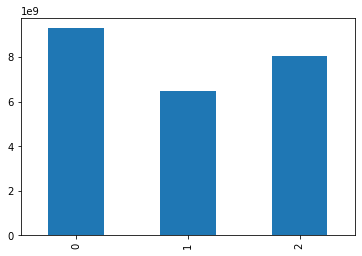

In [23]:
region_selected_df['profit'].plot(kind = 'bar');

* Ниболее прибильные регионы - 0 и 2
* Самый прибыльный регион - 0, прогнозная прибыль составляет порядка 9 млрд.рублей

### Bootstrap

#### Оцениваем только отобранные скважины по регионам

In [24]:
state = np.random.RandomState(12345)

result = []
for _, row in region_selected_df.iterrows():
    # Отбираеми данные
    region = row['region']
    selected = df[df.index.isin(row['data_idx'])]

    profit_values = np.array([])
    loss_values = np.array([])
    for i in range(1000):
        # Определеяем подвыборку
        subselected = selected.sample(frac=1, replace=True, random_state=state)
        features_subselected = subselected.drop(['product', 'id', 'region'], axis=1)
        # Прогнозируем по ним объемы производства
        subpredictions = model.predict(features_subselected)
        # Рассчитываем прибыль
        subprofit =  calc_profit(subpredictions, unit_cost = product_profit, total_budget = budget)
        if subprofit > 0:
            # Сохраняем прибыли
            profit_values = np.append(profit_values, subprofit)
        else:
            # Сохраняем убытки
            loss_values = np.append(loss_values, subprofit)

    # Рассчитываем доверительный интервал 95%
    total_values = np.concatenate([profit_values, loss_values])
    confidence_interval = st.t.interval(0.95, len(total_values)-1, loc = total_values.mean(), scale = st.sem(total_values))
    # Риск убытков
    loss_prob = 100 * len(loss_values) / (len(profit_values) + len(loss_values) )
    # Сохраняем
    result.append({'region': region, 'profit': profit_values.mean(), 'confidence_interval': confidence_interval, 'loss_prob': loss_prob})

        
result = pd.DataFrame.from_records(result)
result

,region,profit,confidence_interval,loss_prob
0,0,3.210413e+10,"(32048020188.31189, 32160231922.66844)",0.0
1,1,3.267582e+10,"(32629272485.59458, 32722370816.874107)",0.0
2,2,3.169243e+10,"(31638468825.552757, 31746392917.583855)",0.0


* Убыточных вариантов нет
* Границы доверительного интервал в 95% очень близко расположены относительно среднего
* Самый высокодоходный регион - 1-ый

#### Оцениваем все скважины по регионам с разбивкой по 200 штук

In [25]:
state = np.random.RandomState(12345)

result = []
for _, row in region_selected_df.iterrows():
    # Отбираеми данные
    region = row['region']
    selected = df.query('region == @region')

    profit_values = []
    loss_values = []
    for i in range(1000):
        # Определеяем подвыборку
        subselected = selected.sample(frac=0.002, replace=True, random_state=state)
        features_subselected = subselected.drop(['product', 'id', 'region'], axis=1)
        # Прогнозируем по ним объемы производства
        subpredictions = model.predict(features_subselected)
        # Рассчитываем прибыль
        subprofit =  calc_profit(subpredictions, unit_cost = product_profit, total_budget = budget)
        if subprofit > 0:
            # Сохраняем прибыли
            profit_values = np.append(profit_values, subprofit)
        else:
            # Сохраняем убытки
            loss_values = np.append(loss_values, subprofit)
    profit_values = pd.Series(profit_values)
    loss_values = pd.Series(loss_values)
    # Рассчитываем доверительный интервал 95%
    total_values = np.concatenate([profit_values, loss_values])
    confidence_interval = st.t.interval(0.95, len(total_values)-1, loc = total_values.mean(), scale = st.sem(total_values))
    confidence_interval2 =(profit_values.quantile(0.025), profit_values.quantile(0.975))
    # Риск убытков
    loss_prob = 100 * len(loss_values) / (len(profit_values) + len(loss_values) )
    # Сохраняем
    result.append({'region': region, 'profit': profit_values.mean(), 'confidence_interval': confidence_interval, 
                   'confidence_interval2': confidence_interval2, 
                   'loss_prob': loss_prob})

        
result = pd.DataFrame.from_records(result)
result

/tmp/ipykernel_36/128502991.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  loss_values = pd.Series(loss_values)
/tmp/ipykernel_36/128502991.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  loss_values = pd.Series(loss_values)


,region,profit,confidence_interval,confidence_interval2,loss_prob
0,0,3.350804e+09,"(3318005339.895702, 3383602394.45604)","(2287956302.4556727, 4381930590.337922)",0.0
1,1,3.940211e+08,"(253000687.12876004, 294693943.52286917)","(29762126.667752266, 970295011.3226571)",20.9
2,2,3.311134e+09,"(3275526143.641733, 3346742067.017185)","(2178512954.0135436, 4456821658.95978)",0.0


#### Адаптированный вариант расчета

In [50]:
state = np.random.RandomState(12345)

result = []
for region in df['region'].unique():
    # Отбираеми данные
    selected = df.query('region == @region')
    
    features = selected.drop(['product','id','region'], axis=1)
    target = selected['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
     features, target, test_size=0.25, random_state=state)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    target = target_valid.reset_index(drop=True)
    predictions = pd.Series(model.predict(features_valid))


    profit_values = np.array([])
    loss_values = np.array([])
    for i in range(1000):
        # Определеяем подвыборку
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        
        # Отбираем топ скважин
        predict_sorted = predictions_sample.sort_values(ascending=False)
        selected_points = target[predict_sorted.index][:region_target_points_qnt]

        # Рассчитываем прибыль
        subprofit =  calc_profit(selected_points, unit_cost = product_profit, total_budget = budget)
        profit_values = np.append(profit_values, subprofit)
     
    profit_values = pd.Series(profit_values)

    # Рассчитываем доверительный интервал 95%
    confidence_interval = (profit_values.quantile(0.025), profit_values.quantile(0.975))
    # Риск убытков
    loss_prob = 100 * (profit_values < 0).mean()
    # Сохраняем
    result.append({'region': region, 'profit': profit_values.mean(), 'confidence_interval': confidence_interval, 'loss_prob': loss_prob})

        
result = pd.DataFrame.from_records(result)
result

,region,profit,confidence_interval,loss_prob
0,0,3.945182e+08,"(-130628446.34041919, 934365552.2936326)",7.8
1,1,4.516128e+08,"(57524865.81233778, 878794357.7669544)",1.3
2,2,3.161286e+08,"(-207785226.29662955, 850700010.2158699)",11.7


In [26]:
def profit(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected_points = target[predict_sorted.index][:region_target_points_qnt]
    product = selected_points.sum()
    revenue = product * product_profit
    return revenue - budget


state = np.random.RandomState(42)

df0 = pd.read_csv('/datasets/geo_data_0.csv')

features = df0.drop(['product','id'], axis=1)
target = df0['product']

features_train, features_valid, target_train, target_valid = train_test_split(
     features, target, test_size=0.25, random_state=state)

model = LinearRegression()
model.fit(features_train, target_train)
predictions_1 = model.predict(features_valid)


target = target_valid.reset_index(drop=True)
predictions = pd.Series(predictions_1)

profit_v=[]
for i in range(1000):
    target_sample = target.sample(500, replace=True, random_state=state)
    predictions_sample = predictions[target_sample.index]
    profit_v.append(profit(target_sample, predictions_sample))
profit_v = pd.Series(profit_v)

mean_profit = profit_v.mean()
confidence_interval = (profit_v.quantile(0.025), profit_v.quantile(0.975))
risk = ((profit_v < 0).mean()* 100, "%")
print("Средняя прибыль =", mean_profit)
print("95%-ый доверительный интервал:", confidence_interval)
print("Риск убытков =", risk)
print()

Средняя прибыль = 426586014.364624
95%-ый доверительный интервал: (-114883436.97132495, 953025757.6441092)
Риск убытков = (6.4, '%')



In [27]:
def profit(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected_points = target[predict_sorted.index][:region_target_points_qnt]
    product = selected_points.sum()
    revenue = product * product_profit
    return revenue - budget


state = np.random.RandomState(42)

df1 = pd.read_csv('/datasets/geo_data_1.csv')

features = df1.drop(['product','id'], axis=1)
target = df1['product']

features_train, features_valid, target_train, target_valid = train_test_split(
     features, target, test_size=0.25, random_state=state)

model = LinearRegression()
model.fit(features_train, target_train)
predictions_1 = model.predict(features_valid)


target = target_valid.reset_index(drop=True)
predictions = pd.Series(predictions_1)

profit_v=[]
for i in range(1000):
    target_sample = target.sample(500, replace=True, random_state=state)
    predictions_sample = predictions[target_sample.index]
    profit_v.append(profit(target_sample, predictions_sample))
profit_v = pd.Series(profit_v)

mean_profit = profit_v.mean()
confidence_interval = (profit_v.quantile(0.025), profit_v.quantile(0.975))
risk = ((profit_v < 0).mean()* 100, "%")
print("Средняя прибыль =", mean_profit)
print("95%-ый доверительный интервал:", confidence_interval)
print("Риск убытков =", risk)
print()

Средняя прибыль = 512328242.007835
95%-ый доверительный интервал: (93042525.53664823, 946531531.0628148)
Риск убытков = (0.8999999999999999, '%')



In [28]:
def profit(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected_points = target[predict_sorted.index][:region_target_points_qnt]
    product = selected_points.sum()
    revenue = product * product_profit
    return revenue - budget


state = np.random.RandomState(42)

df2 = pd.read_csv('/datasets/geo_data_2.csv')

features = df2.drop(['product','id'], axis=1)
target = df2['product']

features_train, features_valid, target_train, target_valid = train_test_split(
     features, target, test_size=0.25, random_state=state)

model = LinearRegression()
model.fit(features_train, target_train)
predictions_1 = model.predict(features_valid)


target = target_valid.reset_index(drop=True)
predictions = pd.Series(predictions_1)

profit_v=[]
for i in range(1000):
    target_sample = target.sample(500, replace=True, random_state=state)
    predictions_sample = predictions[target_sample.index]
    profit_v.append(profit(target_sample, predictions_sample))
profit_v = pd.Series(profit_v)

mean_profit = profit_v.mean()
confidence_interval = (profit_v.quantile(0.025), profit_v.quantile(0.975))
risk = ((profit_v < 0).mean()* 100, "%")
print("Средняя прибыль =", mean_profit)
print("95%-ый доверительный интервал:", confidence_interval)
print("Риск убытков =", risk)
print()

Средняя прибыль = 400842091.35997444
95%-ый доверительный интервал: (-147259901.22117528, 967089641.7419045)
Риск убытков = (7.6, '%')



### Вывод

* Для разработки скважин рекомендуется нулевой или второй регион. Хотя, они менее доходные, чем первый, по ним не прогнозируются убытки
* Максимальная доходность прогнозируется на 0 регионе и составляет от 3.31 до 3.38 млрд руб с 95% вероятностью